# Coche autónomo mediante Deep Learning

Autor: Andrés Martínez Martínez

##Imports

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common use
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# image transformation
from imgaug import augmenters as iaa
from PIL import Image

# machine learning
import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split

print( f'tf.version: {tf.__version__}')
print( f'keras.version: {keras.__version__}')

model_output_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/trained models'

tf.version: 2.8.2
keras.version: 2.8.0


##Load data

In [ ]:
# import images and get a list with its paths
data_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/data/manual-images-v2'
file_list = os.listdir(data_dir)
image_paths = [f'{data_dir}/{name}' for name in file_list if name[-4:] == '.png'] # we only want files with .png extension

# get list of angles from file names, 95 degrees is follow straight
steering_angles = [int(name[-7:-4]) for name in image_paths]

# add a new circuit for validation
ydata_dir = '/content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/data/validation'
yfile_list = os.listdir(ydata_dir)
yimage_paths = [f'{ydata_dir}/{name}' for name in yfile_list if name[-4:] == '.png']
ysteering_angles = [int(name[-7:-4]) for name in yimage_paths]

number of images: 3677
number of angles: 3677


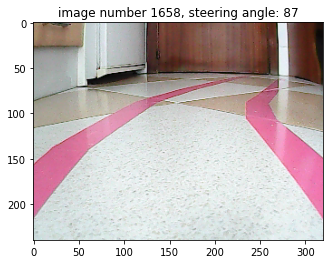

In [ ]:
print('number of images: %d' % len(image_paths+yimage_paths))
print('number of angles: %d' % len(steering_angles+ysteering_angles))

# show an image and its angle
index = np.random.randint(0, len(image_paths) - 1)
plt.imshow(Image.open(image_paths[index]))
plt.title('image number %d, steering angle: %d' % (index, steering_angles[index]))
plt.show()

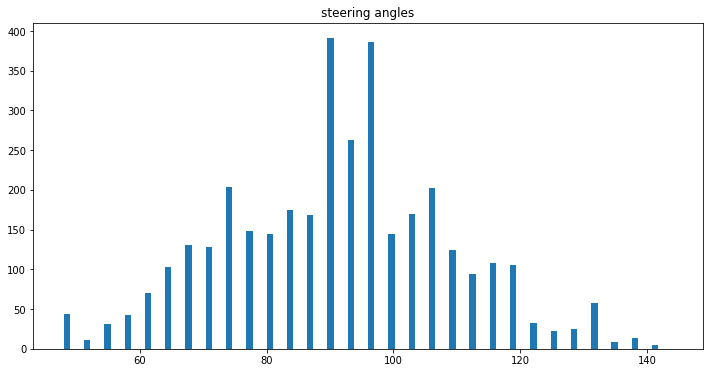

In [ ]:
# check distribution of steering angles
fig, axes = plt.subplots(figsize=(12,6))
plt.hist(steering_angles, bins=30, width=1)
plt.title('steering angles')
plt.show()

# Split and check data

Number of training examples: 3198
Number of validation examples: 479


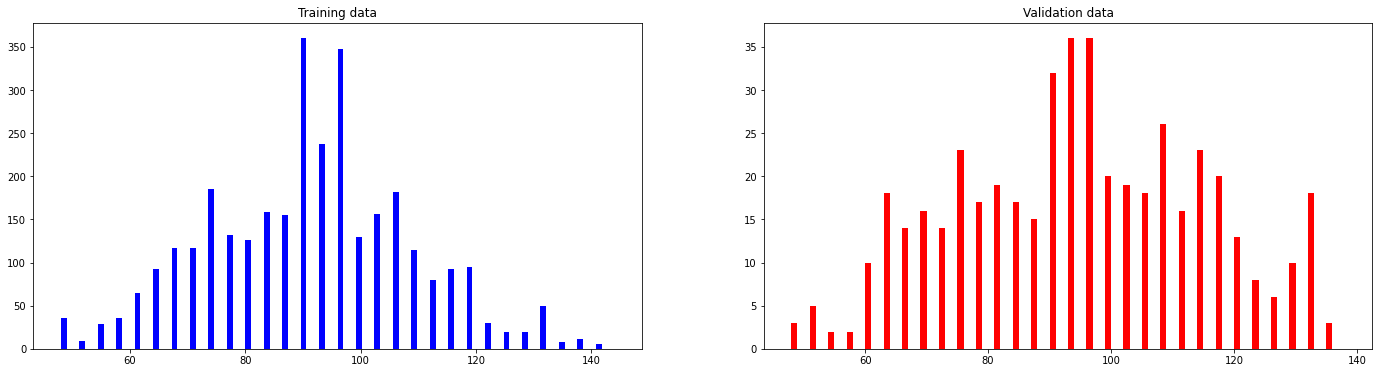

In [ ]:
# split into training and validation sets
paths_train, paths_val, Y_train, Y_val = train_test_split(image_paths, steering_angles, test_size=0.1, random_state=176584)

# add new circuit
paths_val += yimage_paths
Y_val += ysteering_angles
random.Random(562589).shuffle(paths_val)
random.Random(562589).shuffle(Y_val)
print("Number of training examples: %d\nNumber of validation examples: %d" % (len(paths_train), len(paths_val)))

# check distribution of both sets
fig, axes = plt.subplots(1,2, figsize=(24, 6))
axes[0].hist(Y_train, bins=30, width=1, color='blue')
axes[0].set_title('Training data')
axes[1].hist(Y_val, bins=30, width=1, color='red')
axes[1].set_title('Validation data')
plt.show()

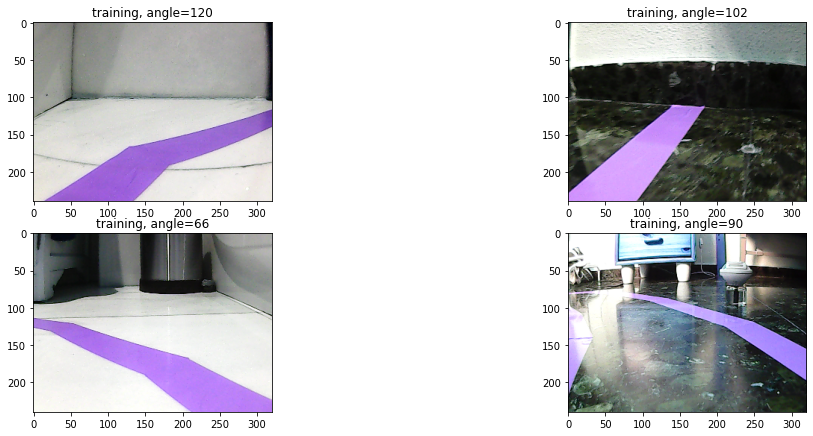

In [ ]:
ncol = 2
nrow = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(cv2.imread(paths_train[i]))
    axes[i][0].set_title(f"training, angle={Y_train[i]}")
    axes[i][1].imshow(cv2.imread(paths_val[i]))
    axes[i][1].set_title(f"training, angle={Y_val[i]}")

##Augment training data

In [ ]:
from tensorflow.python.ops.gen_math_ops import imag_eager_fallback
def augment_images(image_paths, steering_angles):

  aug_images = []
  new_st_angles = []

  for i in range(len(image_paths)):

    image = cv2.imread(image_paths[i])
    aug_images.append(image)
    new_st_angles.append(steering_angles[i])
  
    # add flipped image
    aug_images.append(cv2.flip(image,1))
    new_st_angles.append(180 - steering_angles[i])

  for i in range(len(new_st_angles)):

    #add some blurred images
    if np.random.rand() < 0.5:
      ksize = np.random.randint(1,5)
      aug_images[i] = cv2.blur(aug_images[i], (ksize, ksize))

    #add some images with different brightness
    if np.random.rand() < 0.6:
      brightness = iaa.Multiply((0.7, 1.3))
      bright_image = brightness.augment_image(aug_images[i])

  random.Random(870652).shuffle(aug_images)
  random.Random(870652).shuffle(new_st_angles)

  return aug_images, new_st_angles

def invert_images(image_paths, steering_angles):

  aug_images = []
  new_st_angles = []

  
  
  for i in range(len(image_paths)):

    image = cv2.imread(image_paths[i])
    aug_images.append(image)
    new_st_angles.append(steering_angles[i])
  
    # add flipped image
    aug_images.append(cv2.flip(image,1))
    new_st_angles.append(180 - steering_angles[i])

  random.Random(870652).shuffle(aug_images)
  random.Random(870652).shuffle(new_st_angles)

  return aug_images, new_st_angles

def random_blur(image):
  if np.random.rand() < 0.5:
    ksize = np.random.randint(1,5)
    im = cv2.blur(image, (ksize, ksize))
  return im

def random_brightness(image):
  if np.random.rand() < 0.6:
      brightness = iaa.Multiply((0.7, 1.3))
      im = brightness.augment_image(image)
  return im

def augment(image):
  random_blur(image)
  random_brightness(image)

  return image

##Prepare data

In [ ]:
def image_preprocess(image_path):
  
  image = cv2.imread(image_path)
  
  # cut top of image
  height = len(image)
  image = image[int(height/2):,:,:]

  # resize
  image = cv2.resize(image, (200,66))

  # change to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # normalize
  image = image / 255

  return image

In [ ]:
# create numpy arrays from preprocessed images and previously saved steering angles

X_train = np.asarray([image_preprocess(i) for i in paths_train])
X_val = np.asarray([image_preprocess(i) for i in paths_val])

# double the images thanks to inverting them
images_train, Y_train = invert_images(X_train, Y_val)

Y_train = np.asarray(Y_train)
Y_val = np.asarray(Y_val)

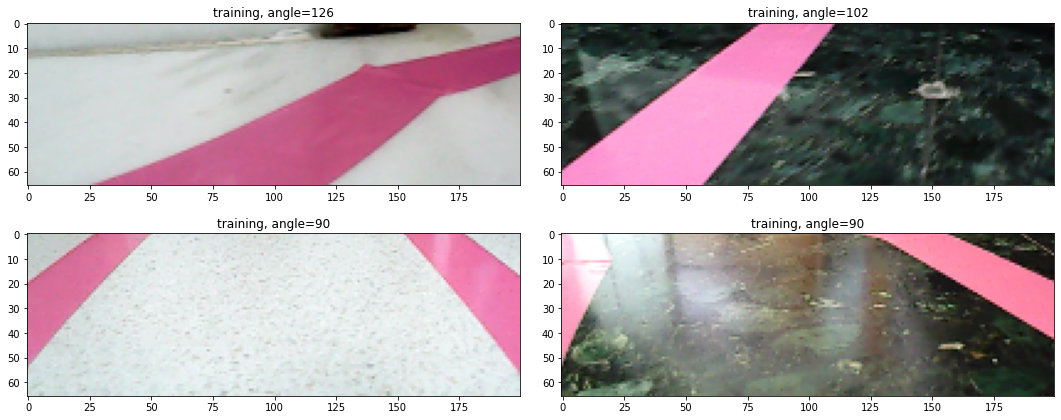

In [11]:
ncol = 2
nrow = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train[i])
    axes[i][0].set_title(f"training, angle={Y_train[i]}")
    axes[i][1].imshow(X_val[i])
    axes[i][1].set_title(f"training, angle={Y_val[i]}")

(6396, 66, 200, 3)
(479, 66, 200, 3)
(6396,)
(479,)


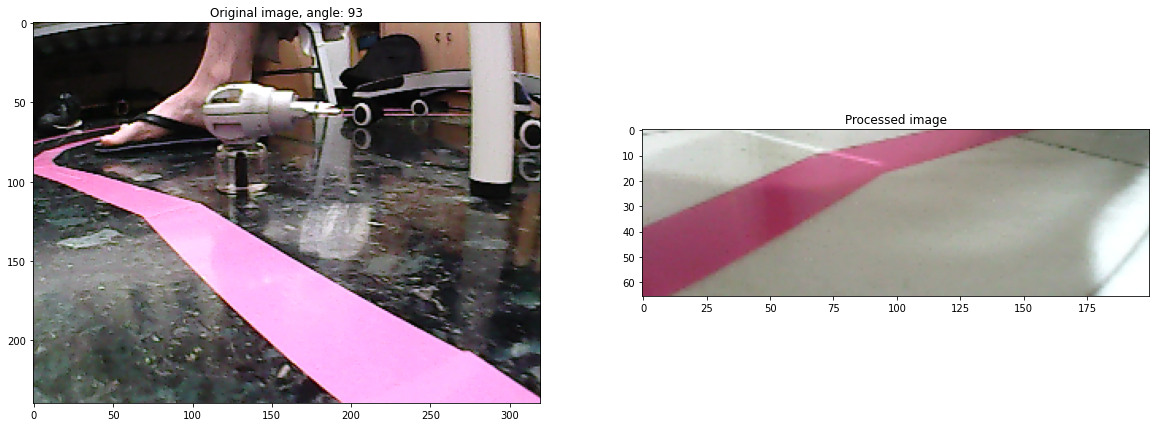

In [12]:
# prints for debugging

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

index = 9
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(Image.open(paths_train[index]))
axes[0].set_title(f'Original image, angle: {Y_train[index]}')
axes[1].imshow(X_train[index])
axes[1].set_title('Processed image')
plt.show()

#Model

In [ ]:
# original size
'''#from keras.backend import relu
def model_nvidia():

  model = keras.Sequential(name='Model_Nvidia')

  # conv layers

  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='elu')) # 38x78 output
  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu')) # 17x37 output
  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu')) # 7x17 output

  model.add(keras.layers.Conv2D(64, 5, activation='elu')) # 3x13 output
  model.add(keras.layers.Conv2D(64, 3, activation='elu')) # 1x11 output

  # fully connected layers
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation='elu'))
  model.add(keras.layers.Dense(50, activation='elu'))
  model.add(keras.layers.Dense(10, activation='elu'))

  # output layer
  model.add(keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=opt)

  return model'''

"#from keras.backend import relu\ndef model_nvidia():\n\n  model = keras.Sequential(name='Model_Nvidia')\n\n  # conv layers\n\n  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(80, 160, 3), activation='elu')) # 38x78 output\n  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu')) # 17x37 output\n  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu')) # 7x17 output\n\n  model.add(keras.layers.Conv2D(64, 5, activation='elu')) # 3x13 output\n  model.add(keras.layers.Conv2D(64, 3, activation='elu')) # 1x11 output\n\n  # fully connected layers\n  model.add(keras.layers.Flatten())\n\n  model.add(keras.layers.Dense(100, activation='elu'))\n  model.add(keras.layers.Dense(50, activation='elu'))\n  model.add(keras.layers.Dense(10, activation='elu'))\n\n  # output layer\n  model.add(keras.layers.Dense(1))\n\n  # loss\n  opt = tf.keras.optimizers.Adam(learning_rate=0.001)\n  model.compile(loss='mse', optimizer=opt)\n\n  return model"

V2

In [15]:
#from keras.backend import relu
def model_nvidia():

  model = keras.Sequential(name='Model_Nvidia')
  
  model.add(tf.keras.layers.RandomContrast(0.2))
  
  # conv layers
  
  model.add(keras.layers.Conv2D(24, 5, strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(keras.layers.Conv2D(36, 5, strides=(2, 2), activation='elu'))
  model.add(keras.layers.Conv2D(48, 5, strides=(2, 2), activation='elu'))
  model.add(keras.layers.Conv2D(64, 3, activation='elu'))
  model.add(keras.layers.Conv2D(64, 3, activation='elu'))

  # fully connected layers
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(100, activation='elu'))
  model.add(keras.layers.Dense(50, activation='elu'))
  model.add(keras.layers.Dense(10, activation='elu'))

  # output layer
  model.add(keras.layers.Dense(1))

  # loss
  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=opt)

  return model

In [16]:
model = model_nvidia()
print(model.summary())

ValueError: ignored

##Training

In [ ]:
history = None

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane-navigation-checkpoint.h5'), verbose=1, save_best_only=True)

history = model.fit(X_train, Y_train, batch_size=32,
                              epochs=25,
                              validation_data = (X_val, Y_val),
                              validation_steps=8,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'lane-navigation.h5'))

Epoch 1/25
200/200 [==============================] - ETA: 0s - loss: 568.7691
Epoch 1: val_loss improved from inf to 449.15942, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/lane-navigation-checkpoint.h5
200/200 [==============================] - 43s 213ms/step - loss: 568.7691 - val_loss: 449.1594
Epoch 2/25
200/200 [==============================] - ETA: 0s - loss: 247.8380
Epoch 2: val_loss improved from 449.15942 to 372.86438, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/lane-navigation-checkpoint.h5
200/200 [==============================] - 43s 212ms/step - loss: 247.8380 - val_loss: 372.8644
Epoch 3/25
200/200 [==============================] - ETA: 0s - loss: 126.9340
Epoch 3: val_loss improved from 372.86438 to 88.37067, saving model to /content/drive/My Drive/Mi educación/TFGs/Smart-Pi-Car/models/lane-navigation/lane-navigation-checkpoint.h5
200/200 [=============================

# Review learning curves

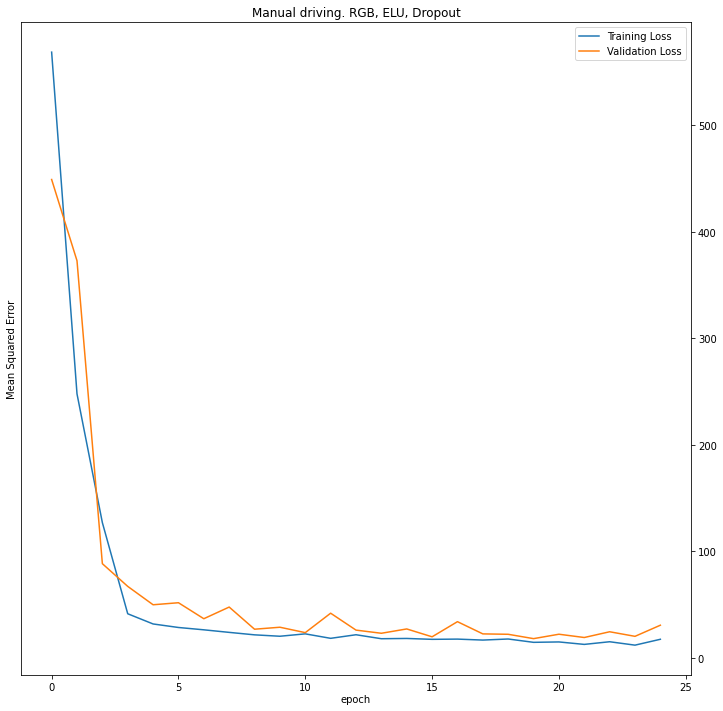

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.plot(loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.title('Manual driving. RGB, ELU, Dropout')
plt.xlabel('epoch',labelpad=2)
ax.yaxis.tick_right()
plt.show()

# Conversión a TF Lite

In [ ]:
os.chdir(f'{model_output_dir}/model3-inverted-other-seed')
model = tf.keras.models.load_model('lane-navigation-checkpoint.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('lane-navigation-model-v3.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpf5414amt/assets


INFO:tensorflow:Assets written to: /tmp/tmpf5414amt/assets
